# Special topics: Web scraping

Web scraping is the process of capturing information from websites. Sometimes this is a simple as copying-and-pasting or downloading a file from the internet, which we have done many times. When it comes to coding, though, we are thinking about searching through websites for series of data sets we want to be able to capture in some sort of process.

[Here](https://blog.hartleybrody.com/web-scraping/) is a nice resource for this that we will use for parts of this topic.

Python packages you made need to install:

* bs4
* requests
* PIL
* io

In [1]:
from bs4 import BeautifulSoup
import requests

## 1. Data

### The data for today

Here is the example we'll be using for this topic: satellite data. A seminar speaker in Oceanography in fall 2015, Dr. Chuanmin Hu, shared with this department about some of his algorithms for satellite data processing. Satellite data gives an incredible spatial scale of information – literally the whole earth! – but require quite a bit of clever processing to get out the data that researchers actually want to use. This becomes increasingly true as we collectively build more complex algorithms to root out new perspectives, and to try to remove visual obstacles like clouds. Dr. Hu, in particular, has found a way to remove sun glint from some satellite data, which can be very useful if you care about a latitude where this tends to be a problem.

Dr. Hu's data is [hosted online](http://optics.marine.usf.edu/); we'll be using it today. Our goal is to select a data type and to then automate the process of downloading a year's worth of image files of that data.

### Fetching data in general

First, some general notes from our resource listed above:

> So the first thing you’re going to need to do is fetch the data. You’ll need to start by finding your “endpoints” — the URL or URLs that return the data you need.

> If you know you need your information organized in a certain way — or only need a specific subset of it — you can browse through the site using their navigation. Pay attention to the URLs and how they change as you click between sections and drill down into sub-sections.

> The other option for getting started is to go straight to the site’s search functionality. Try typing in a few different terms and again, pay attention to the URL and how it changes depending on what you search for. You’ll probably see a GET parameter like q= that always changes based on you search term.

> Try removing other unnecessary GET parameters from the URL, until you’re left with only the ones you need to load your data. Make sure that there’s always a beginning ? to start the query string and a & between each key/value pair.

### Fetching our data in particular

Let's click around on the website. First we should navigate to the Satellite Data Products. We'll try North America > Mississippi River. Notice the web address now:

`http://optics.marine.usf.edu/cgi-bin/optics_data?roi=MRIVER&current=1`

but also note that it doesn't change when we click on other time tabs or dates.

---
### *Exercise*

> Check out April 5, 2016 — there are a lot of neat, unobstructed datasets over several times for different satellite passes for this day. Explore the data. What happens when you click on an image?

---

### Data locations

So we've seen now that any particular satellite data image has its own unique address, for example:

`http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/096/A20160961915.QKM.MRIVER.PASS.L3D_RRC.RGB.png`

and another to compare with:

`http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/096/T20160961605.QKM.MRIVER.PASS.L3D.ERGB.png`

We want to get all of the files like this, but we don't want to file on each and save them by hand. In order to automate downloading this data, we need to search out the unique addresses for each of the times it is available, loop over those addresses, and save the data — pretty simple! The difficult part is deconstructing the webpage in order to automate this process.

Let's take apart this image web address. We see that the first part, `http://optics.marine.usf.edu/subscription/`, is consistent between the two and looks like just a base address. These two images are from different satellites (MODIS-A and MODIS-T, respectively), but they both still have `modis` next in the address. We can guess that `MRIVER` is for Mississippi river, so it is selecting out this particular geographic region. Then we see the year, `2016`, and start getting into what is probably details about this particular file.

---
### *Exercise*

> To navigate through and understand the file system, go to `http://optics.marine.usf.edu/subscription/modis/MRIVER` and click around the links. What does each level of links refer to? How do you navigate to a single image file? What are all the different image files? Which one do you actually want, from the large list of image files you find?

> Out of this exercise, you should come away with a sample link of a particular kind of data you want to automate the selection of, and have an understanding of all the pieces of the web address, such that you know which parts of the address are consistent between different image addresses and what is distinct and would need to be looped over to capture all of these files.

---

## 2. The webpage

Now that we better understand the makeup of the web addresses we'll be using, we need to look at how to take apart the web site in order to dynamically access all of these files. That means, using the bit of knowledge we just gained, we want to be able to mine the necessary data file locations from the website itself with as few things hard-coded in as possible. (The more things we hard-code in, the more likely it is that a minor change on the website will break our code.)

We'll be using [requests](http://docs.python-requests.org/en/latest/index.html) and [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) for this analysis. (For people who have done some of this before, note that Requests is now used preferentially over urllib and urllib2. More [here](http://stackoverflow.com/questions/2018026/what-are-the-differences-between-the-urllib-urllib2-and-requests-module).)

### Accessing the website

We use Requests to access the website, starting with a particular year, 2016. We could instead not specify the year and instead read in all of the years' worth of files, but to limit the scope of our exercise, we'll just use 2016. Note that we have already investigated and seen that "daily" is the only subsequent option on the 2016 page, so we add that in here too.

In [2]:
url = 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/'
# returns a "response" object from the website, then give the text content of that response
restext = requests.get(url).text
restext  # messy

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<html>\n <head>\n  <title>Index of /subscription/modis/MRIVER/2016/daily</title>\n </head>\n <body>\n<h1>Index of /subscription/modis/MRIVER/2016/daily</h1>\n<table><tr><th><img src="/icons/blank.gif" alt="[ICO]"></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr><tr><th colspan="5"><hr></th></tr>\n<tr><td valign="top"><img src="/icons/back.gif" alt="[DIR]"></td><td><a href="/subscription/modis/MRIVER/2016/">Parent Directory</a></td><td>&nbsp;</td><td align="right">  - </td><td>&nbsp;</td></tr>\n<tr><td valign="top"><img src="/icons/folder.gif" alt="[DIR]"></td><td><a href="001/">001/</a></td><td align="right">22-Jan-2016 18:18  </td><td align="right">  - </td><td>&nbsp;</td></tr>\n<tr><td valign="top"><img src="/icons/folder.gif" alt="[DIR]"></td><td><a href="002/">002/</a></td><td align="right">22-Jan-2016 19:

In [3]:
soup = BeautifulSoup(restext, "lxml")  # interprets the text from the website
soup  # more organized

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
<head>
<title>Index of /subscription/modis/MRIVER/2016/daily</title>
</head>
<body>
<h1>Index of /subscription/modis/MRIVER/2016/daily</h1>
<table><tr><th><img alt="[ICO]" src="/icons/blank.gif"/></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr><tr><th colspan="5"><hr/></th></tr>
<tr><td valign="top"><img alt="[DIR]" src="/icons/back.gif"/></td><td><a href="/subscription/modis/MRIVER/2016/">Parent Directory</a></td><td> </td><td align="right">  - </td><td> </td></tr>
<tr><td valign="top"><img alt="[DIR]" src="/icons/folder.gif"/></td><td><a href="001/">001/</a></td><td align="right">22-Jan-2016 18:18  </td><td align="right">  - </td><td> </td></tr>
<tr><td valign="top"><img alt="[DIR]" src="/icons/folder.gif"/></td><td><a href="002/">002/</a></td><td align="right">22-Jan-2016 19:49  </td><td align="right"

---
### *Exercise*

> Figure out how to "View Source" on a website. You might need to google to find this for your browser, but usually you can just right-click and choose the option there. Compare the source for the .../2016/daily webpage with what we see above.

---

What we are seeing here is the makeup of the website, the html. If we look closely, we can pick out what we saw on the website: some header links and then links to each day of files. We want to harvest these links to where files are stored to avoid doing it manually. To do this, we need to think about how we might be able to move through the rows of the file, just like at the beginning of this class when we worked on reading files in line-by-line. We can use the method of a Beautiful Soup object, `findAll`, to pull out text that have certain named types.

For example, below we pull out the part of this site with is a header 1:

In [4]:
soup.findAll('h1')

[<h1>Index of /subscription/modis/MRIVER/2016/daily</h1>]

---
### *Exercise*

> Try sorting the html by other tags. What do you find? We'd like to be able to separately access each link to a day of files. What tag would let us do that?

---

Let's try sorting by the tag 'a', which is for links in html.

In [5]:
soup.findAll('a')

[<a href="?C=N;O=D">Name</a>,
 <a href="?C=M;O=A">Last modified</a>,
 <a href="?C=S;O=A">Size</a>,
 <a href="?C=D;O=A">Description</a>,
 <a href="/subscription/modis/MRIVER/2016/">Parent Directory</a>,
 <a href="001/">001/</a>,
 <a href="002/">002/</a>,
 <a href="003/">003/</a>,
 <a href="004/">004/</a>,
 <a href="005/">005/</a>,
 <a href="006/">006/</a>,
 <a href="007/">007/</a>,
 <a href="008/">008/</a>,
 <a href="009/">009/</a>,
 <a href="010/">010/</a>,
 <a href="011/">011/</a>,
 <a href="012/">012/</a>,
 <a href="013/">013/</a>,
 <a href="014/">014/</a>,
 <a href="015/">015/</a>,
 <a href="016/">016/</a>,
 <a href="017/">017/</a>,
 <a href="018/">018/</a>,
 <a href="019/">019/</a>,
 <a href="020/">020/</a>,
 <a href="021/">021/</a>,
 <a href="022/">022/</a>,
 <a href="023/">023/</a>,
 <a href="024/">024/</a>,
 <a href="025/">025/</a>,
 <a href="026/">026/</a>,
 <a href="027/">027/</a>,
 <a href="028/">028/</a>,
 <a href="029/">029/</a>,
 <a href="030/">030/</a>,
 <a href="031/">03

Ok! So we found something here maybe. The first few entries are for links that seem to be a header at the top of the page; in fact, we can compare with other pages to see that it is consistent. So, let's use this to grab all the links we want to gather, and just skip the first few entries.

How can we access each of these sub-webpages using what we have here?

In [6]:
row = soup.findAll('a')[5]  # grab the first row that contains a link we want
print('row:\n', row, '\n')

row:
 <a href="001/">001/</a> 



But we need this in the form of another web address:

In [7]:
url + row.string  # .string() returns just the string inside the object

'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/001/'

Now that we have an address, we can access it the same way we did for the first website:

In [8]:
restext = requests.get(url + row.string).text  # access text on new website
soup_dir = BeautifulSoup(restext, "lxml")  # open up page for a day
soup_dir

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
<head>
<title>Index of /subscription/modis/MRIVER/2016/daily/001</title>
</head>
<body>
<h1>Index of /subscription/modis/MRIVER/2016/daily/001</h1>
<table><tr><th><img alt="[ICO]" src="/icons/blank.gif"/></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr><tr><th colspan="5"><hr/></th></tr>
<tr><td valign="top"><img alt="[DIR]" src="/icons/back.gif"/></td><td><a href="/subscription/modis/MRIVER/2016/daily/">Parent Directory</a></td><td> </td><td align="right">  - </td><td> </td></tr>
<tr><td valign="top"><img alt="[IMG]" src="/icons/image2.gif"/></td><td><a href="A20160010720.QKM.MRIVER.PASS.L3D.SST.200.png">A20160010720.QKM.MRIVER.PASS.L3D.SST.200.png</a></td><td align="right">22-Jan-2016 06:47  </td><td align="right">1.7K</td><td> </td></tr>
<tr><td valign="top"><img alt="[IMG]" src="/icons/image2.gif"/></

We can again compare this with the website itself to help understand what we are seeing: another list of links.

---
### *Exercise*

> We already spent time earlier understanding what the different parts of the web address for an image file represents. So, find the sort of file that you want from the available options for this day. Which variable do you want to access? Which size image? Note that there is more than one time per day and more than one satellite data source.

---

Now we can now set up a loop to loop over the lines with links on both the first page (list of links to the daily page) and the second (list of links of files from a given day).

In [9]:
image_locs = []
for row in soup.findAll('a')[5:20]:  # loop through each day, but only do first part of Jan 2016 to save time
    
    restext = requests.get(url + row.string).text
    soup_dir = BeautifulSoup(restext, "lxml")  # open up page for a day
    
    for File in soup_dir.findAll('a')[5:]:  # find all files for this day

        # search for the image file we want, might be more than one for a day
        fname = '.QKM.MRIVER.PASS.L3D_RRC.RGB.png'

        if fname in File.string:  # check for which link on this page is the data we want
            image_locs.append(url + row.string + File.string)  # save file address

Now we have all of the web addresses for the data files of this type for 2016:

In [10]:
image_locs

['http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/001/A20160011820.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/001/A20160012000.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/001/T20160011645.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/002/A20160021905.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/002/T20160021550.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/002/T20160021730.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/003/A20160031945.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modis/MRIVER/2016/daily/003/T20160031635.QKM.MRIVER.PASS.L3D_RRC.RGB.png',
 'http://optics.marine.usf.edu/subscription/modi

Our next step would be to read in the data from these addresses, with something like the following:

In [11]:
from PIL import Image
from io import BytesIO
import numpy as np

response = requests.get(image_locs[10])  # choose one of the files to show as an example
img = Image.open(BytesIO(response.content))
foo = np.asarray(img)

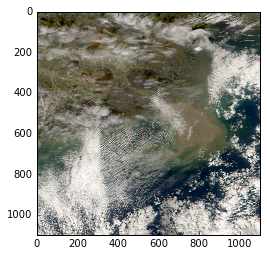

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

if np.ndim(foo) == 3:  # this is for real color image
    plt.imshow(foo)
elif np.ndim(foo) == 2:
    plt.pcolormesh(foo)

But, we will talk about image processing in a subsequent class.

## 3. Result

I did these steps previously in order to gather relevant satellite data for my research on my own computer so I could use it, and in order to make the plots myself and use better colormaps.

[Here](https://github.com/kthyng/sat/blob/master/plot_sat.py) is my code for that effort. You will recognize a lot of it!

And [here](http://pong.tamu.edu/~kthyng/projects/sat/figures/) are the satellite images I made.